# Viscosity calculations for methyl cellulose - PBS solutions for RT-DC

This notebook shows how the viscosity calculations introduced by Büyükrganci et al. are put into practice.

The general formalism goes as follows:

The viscosity is described by a power law of the shear rate: $$\eta = K\cdot\dot\gamma^{n-1}$$

The factors $K$ and $n$ are temperature dependent. The temperature dependence can be described with the following equations:
$$n=\alpha\cdot T + \beta$$
$$K=A\cdot e^{\lambda/T}$$

The values were determined for buffers with MC concentrations 0.49 w%, 0.59 w% and 0.83 w%. It showed that the factors $\alpha$ and $\lambda$ did not show any trend with concentration and can be seen as material constants of MC in PBS solution, for the concentrations studied in the paper. Therefore, we take the average values of $\alpha$ and $\lambda$ to describe the temperature behavior of all buffers. Otherwise, the curves presented in the paper can intersect, leading to a lower viscosity for the 0.59% solution compared to the 0.49% solution under certain conditions.
The values for the different MC-solutions are (value$\pm$SD):

![](imgs/BB_et_al_table_S3.png)

This leads to the following averages:

In [1]:
import numpy as np

In [2]:
alpha = [0.0022, 0.0024, 0.0021]
alpha_mean = np.mean(alpha)
alhpa_sd = np.std(alpha)
alpha_sem = alhpa_sd / np.sqrt(len(alpha))
alpha_err_mean = np.mean([0.0004, 0.0003, 0.0004])

lambdas = [3691.8, 3095.6, 3351.6]
lambda_mean = np.mean(lambdas)
lambda_sd = np.std(lambdas)
lambda_sem = lambda_sd / np.sqrt(len(lambdas))
lambda_err_mean = np.mean([475.2, 242.5, 412.4])

print("Mean +\- SEM +\- error propagation")
print("alpha = {:.5f} +/- {:.5f} +/- {:.5f}".format(alpha_mean, alpha_sem, alpha_err_mean))
print("lambda = {:.1f} +/- {:.1f} +/- {:.1f}".format(lambda_mean, lambda_sem, lambda_err_mean))

Mean +\- SEM +\- error propagation
alpha = 0.00223 +/- 0.00007 +/- 0.00037
lambda = 3379.7 +/- 141.0 +/- 376.7


Redo the temperature fitting for the fixed values of $\alpha$ and $\lambda$ to get the final viscosity curves:

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import LogFormatterSciNotation
sns.set_style('darkgrid')

In [4]:
path = r'raw_data\20220113_fitting_parameters.xlsx'

df_all = pd.read_excel(path, header=0)
df_n = pd.read_excel(path, sheet_name='n', header=0)
df_K = pd.read_excel(path, sheet_name='K', header=0)
temp_kelvin = 273 + df_all['Temperature']
df_all['temp_kelvin'] = temp_kelvin
df_n = pd.read_excel(path, sheet_name='n', header=0)
df_n['temp_kelvin'] = temp_kelvin
df_K = pd.read_excel(path, sheet_name='K', header=0)
df_K['temp_kelvin'] = temp_kelvin

### Linear fitting of parameter n with fixed $\alpha$
##### $n = \alpha\cdot T + \beta$, $\bar\alpha =0.00223\,$1/K

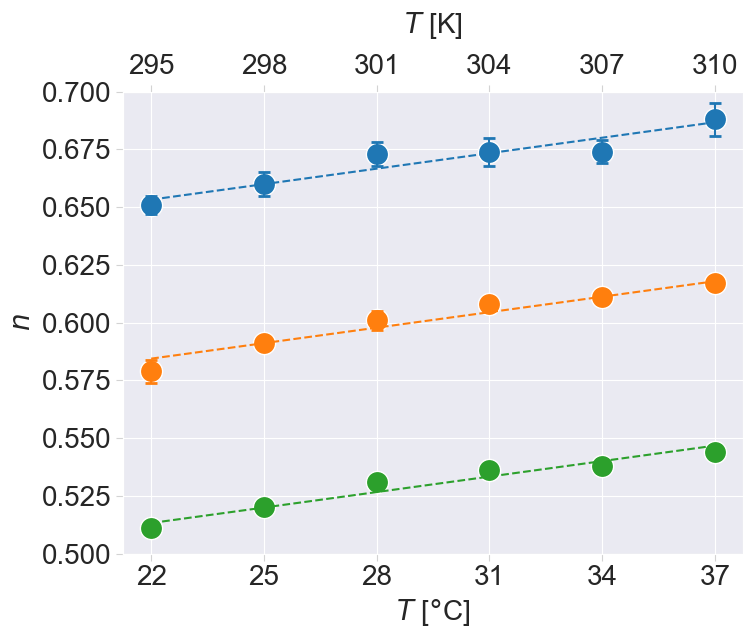

In [5]:
fontsize = 20
df_fit_fixed_a = pd.DataFrame()
mc_concentrations = df_n['Buffer'].unique()
pal = sns.color_palette('tab10')

fig = plt.figure(0, (8, 6))
ax1 = plt.subplot(111)
ax2 = ax1.twiny()

for ii, conc in enumerate(mc_concentrations):
    data_conc = df_n[df_n['Buffer'] == conc]
    data_T = data_conc['temp_kelvin']
    data_n = data_conc['n']
    n_error = data_conc['n_error']

    # intercept that best fits the data, given a fixed slope
    b = np.mean(data_n - alpha_mean*data_T)
    b_err = np.std(data_n - alpha_mean*data_T) / np.sqrt(len(data_T))

    ax1.plot(data_T, data_n, 'o', c=pal[ii],
             markersize=16, markeredgecolor='w',
             label=conc)
    ax1.plot(data_T, alpha_mean*data_T + b, '--', c=pal[ii]
             )
    ax1.errorbar(data_T, data_n, yerr=n_error,
                 xerr=None, ls='None', capsize=4, capthick=2)
    data_dict = {'b': [b],
                 'b_err': [b_err],
                 'buffer': [conc]
                 }
    df_fit_fixed_a = pd.concat([df_fit_fixed_a, pd.DataFrame(data_dict)])

ax1.set_ylim(0.5, 0.7)
xlabel = r"$T$ [$\degree$C]"
ax1.set_xlabel(xlabel, fontsize=fontsize)
ax1.set_ylabel(r"$n$", fontsize=fontsize)

ax1.tick_params(reset=True, axis='both', which='major', labelsize=fontsize, length=5,
                top=False, right=False, color='lightgray')
xtick_positions = [295, 298, 301, 304, 307, 310]
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(['22', '25', '28', '31', '34', '37'])

xlabel_top = r"$T$ [K]"
ax2.set_xlabel(xlabel_top, fontsize=fontsize, labelpad=15)
xlims = ax1.get_xlim()
ax2.set_xlim(xlims)
ax2.set_xticks(xtick_positions)
ax2.set_xticklabels(['295', '298', '301', '304', '307', '310'])
ax2.tick_params(axis='x', labelsize=fontsize, length=5, color='lightgray')
ax2.grid(False)
# ax1.legend(loc='upper left', fontsize=fontsize-2)

savename = "plots//n_vs_t"
fig.savefig(savename+".pdf", bbox_inches='tight',dpi=900)
fig.savefig(savename+".png", bbox_inches='tight', dpi=900)

plt.show()

In [6]:
df_fit_fixed_a

b     b_err        buffer
0 -0.005583  0.001527  0.49% MC-PBS
0 -0.074417  0.001208  0.59% MC-PBS
0 -0.145583  0.001090  0.83% MC-PBS

### Exponential fitting of parameter K with fixed $\lambda$
##### $K = A\cdot \exp\left(\frac{\lambda}{T}\right)$, $\bar\lambda =3378\,$K

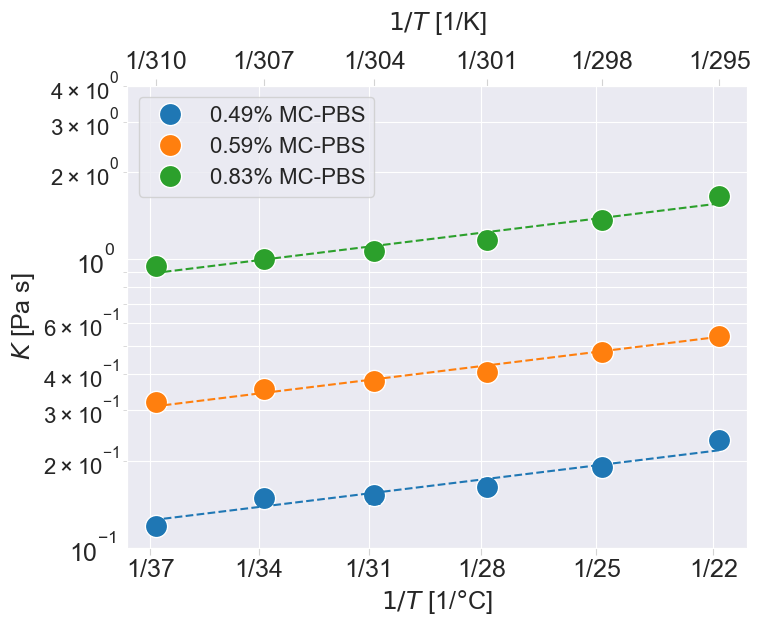

In [7]:
fontsize = 18
df_fit_K_fixed_l = pd.DataFrame()
mc_concentrations = df_K['Buffer'].unique()
pal = sns.color_palette('tab10')

fig = plt.figure(0, (8,6))
ax1 = plt.subplot(111)
ax2 = ax1.twiny()
for ii, conc in enumerate(mc_concentrations):
    data_conc = df_K[df_K['Buffer'] == conc]
    data_T = data_conc['temp_kelvin']
    data_K = data_conc['K']
    log_K = np.log(data_K)
    reverse_T = np.divide(1.,data_T)
    K_error = data_conc['K_error']

    # intercept that best fits the data, given a fixed slope
    ict = np.mean(log_K - lambda_mean*reverse_T)
    ict_err = np.std(log_K - lambda_mean*reverse_T) / np.sqrt(len(reverse_T))
    A = np.exp(ict)
    A_err = A * ict_err

    ax1.plot(reverse_T, data_K, 'o', c=pal[ii],
             markersize=16, markeredgecolor='w',
             label=conc)
    ax1.plot(reverse_T, A * np.exp(lambda_mean * reverse_T),
             '--', c=pal[ii])
    ax1.errorbar(reverse_T, data_K, yerr=K_error,
                 xerr=None, ls='None', capsize=4, capthick=2)
    data_dict = {'buffer': [conc],
                 'A': [A],
                 'A_err': [A_err],
                 }
    df_fit_K_fixed_l = pd.concat([df_fit_K_fixed_l, pd.DataFrame(data_dict)])

ax1.set(yscale="log")
ax2.set(yscale='log')
ax2.set(xscale='linear')

ax1.set_ylim(0.1, 4)
xlabel = r"$1/T$ [1/$\degree$C]"
ax1.set_xlabel(xlabel, fontsize=fontsize)
ax1.set_ylabel(r"$K$ [Pa s]", fontsize=fontsize)

xtick_positions = [1/310.15, 1/307.15, 1/304.15, 1/301.15, 1/298.15, 1/295.15]
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(['1/37', '1/34', '1/31', '1/28', '1/25', '1/22'])
ax1.tick_params(#reset=True,
                axis='both', which='major', labelsize=fontsize, length=5,
                top=False, right=False, color='lightgray')
ax1.tick_params(reset=True,
                axis='both', which='minor', labelsize=fontsize - 2, length=3,
                top=False, right=False, color='lightgray')
y_minor_formatter = LogFormatterSciNotation(base=10, labelOnlyBase=False, minor_thresholds=(3,0))
ax1.yaxis.set_minor_formatter(y_minor_formatter)

ax1.grid(which='both', zorder=1)

xlims = ax1.get_xlim()
ax2.set_xlim(xlims)
xtick_positions = [1/310, 1/307, 1/304, 1/301, 1/298, 1/295]
ax2.set_xticks(xtick_positions)
ax2.set_xticklabels(['1/310', '1/307', '1/304', '1/301', '1/298', '1/295'])

ax2.tick_params(axis='x', labelsize=fontsize, length=5, color='lightgray')
xlabel_top = r"$1/T$ [1/K]"
ax2.set_xlabel(xlabel_top, fontsize=fontsize, labelpad=15)
ax2.grid(False)

ax1.legend(loc='upper left', fontsize=fontsize-2)

savename = "plots//k_vs_t"
fig.savefig(savename+".pdf", bbox_inches='tight',dpi=900)
fig.savefig(savename+".png", bbox_inches='tight', dpi=900)

plt.show()

In [10]:
df_fit_K_fixed_l['A 10^-6'] = df_fit_K_fixed_l['A'] * 1e6
df_fit_K_fixed_l

buffer         A         A_err    A 10^-6
0  0.49% MC-PBS  0.000002  5.266961e-08   2.302216
0  0.59% MC-PBS  0.000006  7.323246e-08   5.696597
0  0.83% MC-PBS  0.000017  3.118066e-07  16.517648

In [9]:
print(df_fit_K_fixed_l['A'].to_numpy())

[2.30221618e-06 5.69659681e-06 1.65176477e-05]


## Summary

The resulting values $\alpha$ and $\lambda$ are:

$\bar\alpha = \left(2.23 \pm 0.44\right) \times 10^{-3}\,$1/K

$\bar\lambda = \left(3379.7 \pm 517.1\right)\,$K

And the other values are:

![](imgs/20230117_new_fit_paras.png)

This leads to the following final equations for the MC solutions:

0.49% MC-PBS:  $~~\eta\left(T,\dot\gamma\right) = 2.30\cdot 10^{-6}\cdot \exp\left(3379.7\frac{[\text{K}]}{T}\right)\cdot\left(\frac{\gamma}{\gamma_0}\right)^{0.00223\frac{T}{[\text{K}]} - 1.0056}\,$Pa s

0.59% MC-PBS:  $~~\eta\left(T,\dot\gamma\right) = 5.70\cdot 10^{-6}\cdot \exp\left(3379.7\frac{[\text{K}]}{T}\right)\cdot\left(\frac{\gamma}{\gamma_0}\right)^{0.00223\frac{T}{[\text{K}]} - 1.0744}\,$Pa s

0.83% MC-PBS:  $~~\eta\left(T,\dot\gamma\right) = 16.52\cdot 10^{-6}\cdot \exp\left(3379.7\frac{[\text{K}]}{T}\right)\cdot\left(\frac{\gamma}{\gamma_0}\right)^{0.00223\frac{T}{[\text{K}]} - 1.1455}\,$Pa$\,$s